In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n = 100
d = 50
split_size = 0.2 # proportion of datapoints for test set

f = lambda x: (5*x[0]**3) + (2*x[1]**2) + (10*x[2])

X_train = np.random.normal(size=(int(n*(1-split_size)),d))
X_test = np.random.normal(size=(int(n*split_size),d))
y_train = np.array([f(x) for x in X_train])
y_test = np.array([f(x) for x in X_test])

In [3]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80, 50), (20, 50), (80,), (20,))

In [4]:
X_train[0]

array([-0.78121106, -0.33617641,  0.52363846, -0.13496118,  0.03644554,
        1.00639938,  0.57238661,  0.46756195, -0.67469437, -0.39055475,
       -0.06936906, -0.88518766,  1.46465732, -1.65444732, -1.88602962,
        0.44376697,  0.73790899, -0.08182475, -0.11184231,  0.67887083,
        0.16207671,  0.73973256, -2.17877134,  0.41545317, -0.36186587,
        0.18273438, -0.49650448,  0.59107204, -0.2078507 ,  0.12309621,
        0.96816116, -0.92652852, -0.55756205,  0.4023395 ,  0.33890383,
       -0.12658214,  0.04695529, -0.81467258,  1.6463466 ,  0.28324913,
       -0.40857785, -1.17332751, -1.23109783,  0.36033934, -1.29731062,
       -2.93319246, -2.71695021,  0.32859046, -0.25965966, -1.48903463])

In [5]:
y_train[0]

3.078584437185568

In [6]:
def mnorm(x, z, M, squared=True): # (n, d), (m,d), (d,d) --> (n, m)
    # implements |x-z|_M^2 between pairs from x and z
    x_norm = ((x @ M)*x).sum(axis=1, keepdims=True)
    if x is z:
        z_norm = x_norm
    else:
        z_norm = ((z @ M)*z).sum(axis=1, keepdims=True)
        
    z_norm = z_norm.reshape(1, -1)
    
    distances = (x @ (M @ z.T)*-2) + x_norm + z_norm
    if not squared:
        distances = np.sqrt(np.clip(distances, 0, np.inf))
    return distances

In [7]:
M = np.eye(d)

mnorm(X_train, X_train, M, squared=False)

array([[0.00000000e+00, 9.36131780e+00, 1.11844848e+01, ...,
        1.00254031e+01, 1.02498088e+01, 1.16892037e+01],
       [9.36131780e+00, 0.00000000e+00, 8.90060413e+00, ...,
        8.93452226e+00, 9.12126509e+00, 1.02345404e+01],
       [1.11844848e+01, 8.90060413e+00, 0.00000000e+00, ...,
        9.52964760e+00, 9.41369844e+00, 1.01657494e+01],
       ...,
       [1.00254031e+01, 8.93452226e+00, 9.52964760e+00, ...,
        1.19209290e-07, 9.80113169e+00, 1.01280987e+01],
       [1.02498088e+01, 9.12126509e+00, 9.41369844e+00, ...,
        9.80113169e+00, 0.00000000e+00, 9.52203742e+00],
       [1.16892037e+01, 1.02345404e+01, 1.01657494e+01, ...,
        1.01280987e+01, 9.52203742e+00, 0.00000000e+00]])

In [8]:
def K_M(x, z, M, L):
    pairwise_distances = mnorm(x, z, M, squared=False)
    pairwise_distances = np.clip(pairwise_distances, 0, np.inf)
    return np.exp(pairwise_distances * -(1./L))

def grad_laplace_mat(a, x, z, M, L): # (n, d), (m, d), (d, d) --> (n, m, d)
    dist = mnorm(x, z, M, squared=False)
    dist = np.where(dist < 1e-4, np.zeros(1, dtype=np.float16), dist)
    
    K = K_M(x, z, M, L)/dist
    K[K == float('inf')] = 0.
    
    a = a[:, None]
    
    n, d = x.shape
    n, c = a.shape
    m, d = z.shape
    
    a = a.reshape(n, c, 1)
    X1 = (x @ M).reshape(n, 1, d)
    step1 = (a @ X1).reshape(-1, c*d)
    
    step2 = (K.T @ step1).reshape(-1, c, d)
    del step1
    
    step3 = ((a.T @ K).T).reshape(m, c, 1)
    z1 = (z @ M).reshape(m, 1, d)
    step3 = step3 @ z1
    
    G = (step2 - step3) * -1/L
    
    return G
    
    # nm_factor = np.where(
    #     mnorm(x, z, M) < 1e-4, 0, K_M(x, z, M, L)/mnorm(x, z, M, squared=False)/L)
    # np.fill_diagonal(nm_factor, 0.)
    # return ((z @ M) - (x @ M)[:,None,:]) * nm_factor[:,:,None]

In [9]:
T = 10
L = 1.
M = np.eye(d)

_lambda = 1e-3


def train_rfm(X_train, y_train, L=1., T=10):
    M = np.eye(d)
    for t in range(T):
        K_train = K_M(X_train, X_train, M, L=L)
        alpha = y_train @ np.linalg.pinv(K_train + _lambda*np.eye(80))
        grad = grad_laplace_mat(alpha, X_train, X_train, M, L=L)
        M = np.mean(np.swapaxes(grad, 1, 2) @ grad, axis=0)
        
    return alpha, M

alpha, M = train_rfm(X_train, y_train, L, T)

/var/folders/mc/421h_39x625fpy09_jss5vrh0000gn/T/ipykernel_97178/1190691096.py:10: RuntimeWarning: divide by zero encountered in true_divide
  K = K_M(x, z, M, L)/dist


In [10]:
alpha.shape, M.shape

((80,), (50, 50))

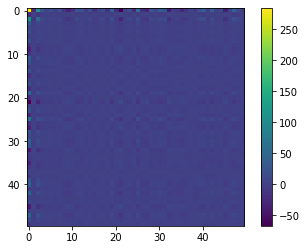

In [326]:
plt.imshow(M)
plt.colorbar()

In [319]:
y_pred_train = alpha @ K_M(X_train, X_train, M, L)
((y_train - y_pred_train)**2).mean()

17.076659043639626

In [11]:
K_M(X_train, X_test, M, L).shape

(80, 20)

In [320]:
y_pred_test = alpha @ K_M(X_train, X_test, M, L)
((y_test - y_pred_test)**2).mean()

496.33504160827397

In [269]:
train_MSE = []
test_MSE = []

for d in range(10, 200, 2):
    # generate data
    train_X = X_train[:, :d]
    test_X = X_test[:, :d]
    
    alpha, M = train_rfm(train_X, y_train, L, T)
    
    # train mse
    y_pred_train = alpha @ K_M(train_X, train_X, M, L)
    train_MSE.append(((y_train - y_pred_train)**2).mean())
    
    # test mse
    y_pred_test = alpha @ K_M(train_X, test_X, M, L)
    test_MSE.append(((y_test - y_pred_test)**2).mean())

/var/folders/mc/421h_39x625fpy09_jss5vrh0000gn/T/ipykernel_79221/1190691096.py:10: RuntimeWarning: divide by zero encountered in true_divide
  K = K_M(x, z, M, L)/dist


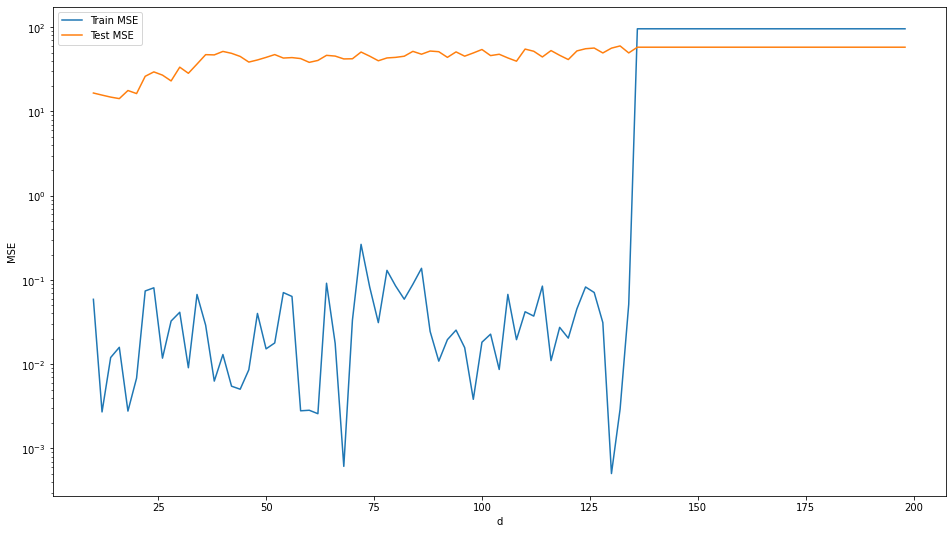

In [277]:
d_range = list(range(10, 200, 2))

plt.figure(figsize=(16,9))
plt.plot(d_range, train_MSE, label="Train MSE")
plt.plot(d_range, test_MSE, label="Test MSE")
plt.xlabel("d")
plt.ylabel("MSE")
plt.yscale("log")
plt.legend()

In [282]:
M

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [281]:
np.linalg.eig(M)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0.

In [321]:
# check error bounds on subsetting for gradient approximation
# eigenvalues/vectors of M
# try M^2, M^3, ...
# text datasets